In [65]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [76]:
cvd_df = pd.read_csv('../cardio_data_processed.csv')
cvd_df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1,Hypertension Stage 1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2,Hypertension Stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1,Hypertension Stage 1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2,Hypertension Stage 2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal,Normal
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0,60,29.384676,Hypertension Stage 1,Hypertension Stage 1
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0,60,37.729725,Hypertension Stage 1,Hypertension Stage 1
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1,61,29.983588,Hypertension Stage 1,Hypertension Stage 1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0,48,28.440955,Normal,Normal
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0,54,25.282570,Normal,Normal


In [78]:
# Dropped age and bp_category_encoded files. Age is just age in days, kept age in years, bp_category_encoded files
# repeats of bp_category column
cvd_df = cvd_df.drop(columns=['age','bp_category_encoded'])
cvd_df

,id,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category
0,0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1
1,1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2
2,2,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1
3,3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2
4,4,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68200,99993,2,168,76.0,120,80,1,1,1,0,1,0,52,26.927438,Hypertension Stage 1
68201,99995,1,158,126.0,140,90,2,2,0,0,1,1,61,50.472681,Hypertension Stage 2
68202,99996,2,183,105.0,180,90,3,1,0,1,0,1,52,31.353579,Hypertension Stage 2
68203,99998,1,163,72.0,135,80,1,2,0,0,0,1,61,27.099251,Hypertension Stage 1


In [79]:
cvd_df.describe()

,id,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
count,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000,68205.000000
mean,49972.410498,1.348625,164.372861,74.100688,126.434924,81.263925,1.363243,1.225174,0.087662,0.053134,0.803548,0.493688,52.823635,27.510513
std,28852.138290,0.476539,8.176756,14.288862,15.961685,9.143985,0.678080,0.571288,0.282805,0.224302,0.397317,0.499964,6.769909,6.026497
min,0.000000,1.000000,55.000000,11.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.000000,3.471784
25%,24991.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.875115
50%,50008.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.000000,26.346494
75%,74878.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,30.116213
max,99999.000000,2.000000,250.000000,200.000000,180.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.000000,298.666667


In [80]:
cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           68205 non-null  int64  
 1   gender       68205 non-null  int64  
 2   height       68205 non-null  int64  
 3   weight       68205 non-null  float64
 4   ap_hi        68205 non-null  int64  
 5   ap_lo        68205 non-null  int64  
 6   cholesterol  68205 non-null  int64  
 7   gluc         68205 non-null  int64  
 8   smoke        68205 non-null  int64  
 9   alco         68205 non-null  int64  
 10  active       68205 non-null  int64  
 11  cardio       68205 non-null  int64  
 12  age_years    68205 non-null  int64  
 13  bmi          68205 non-null  float64
 14  bp_category  68205 non-null  object 
dtypes: float64(2), int64(12), object(1)
memory usage: 7.8+ MB


In [81]:
cvd_df.nunique()

id             68205
gender             2
height           106
weight           278
ap_hi             86
ap_lo             58
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
age_years         28
bmi             3752
bp_category        4
dtype: int64

In [82]:
cvd_df.isnull().sum()

id             0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
age_years      0
bmi            0
bp_category    0
dtype: int64

In [83]:
cvd_df.duplicated().sum()

0

In [110]:
cvd_df_corr = pd.get_dummies(cvd_df)
print(cvd_df_corr.corr())

                                        id    gender    height    weight  \
id                                1.000000  0.002853 -0.002884 -0.002023   
gender                            0.002853  1.000000  0.498323  0.156027   
height                           -0.002884  0.498323  1.000000  0.292679   
weight                           -0.002023  0.156027  0.292679  1.000000   
ap_hi                             0.000251  0.060722  0.018544  0.268289   
ap_lo                            -0.001090  0.066126  0.035550  0.250184   
cholesterol                       0.006092 -0.037397 -0.050957  0.139816   
gluc                              0.002225 -0.021822 -0.019317  0.105734   
smoke                            -0.003925  0.337758  0.187543  0.067169   
alco                              0.000754  0.170719  0.094354  0.067177   
active                            0.003539  0.005206 -0.008241 -0.017443   
cardio                            0.003808  0.006098 -0.011276  0.177829   
age_years   

<Axes: >

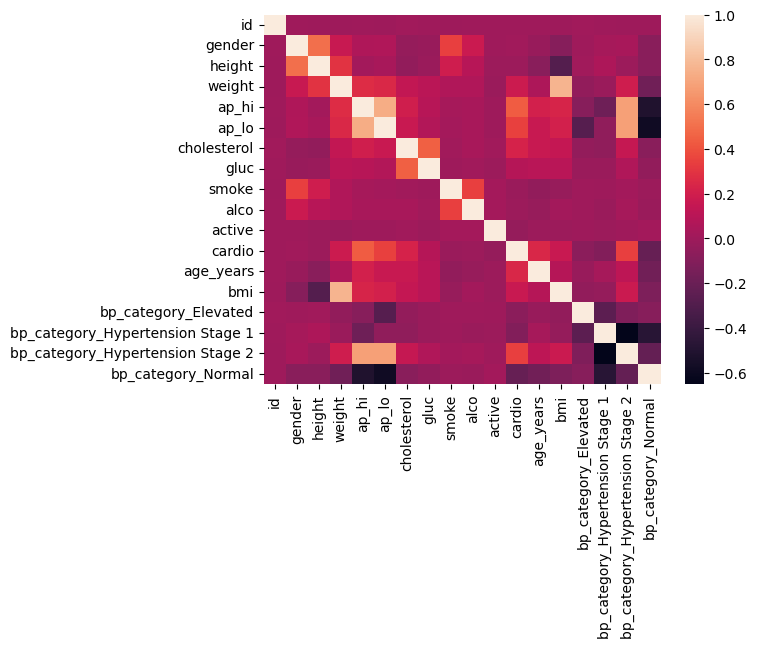

In [112]:
sns.heatmap(cvd_df_corr.corr(), annot=False)

In [84]:
X = cvd_df.drop(columns = ['cardio', 'id'])
y = cvd_df['cardio']

In [85]:
X = pd.get_dummies(X, dtype='int')

In [86]:
X

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,bp_category_Elevated,bp_category_Hypertension Stage 1,bp_category_Hypertension Stage 2,bp_category_Normal
0,2,168,62.0,110,80,1,1,0,0,1,50,21.967120,0,1,0,0
1,1,156,85.0,140,90,3,1,0,0,1,55,34.927679,0,0,1,0
2,1,165,64.0,130,70,3,1,0,0,0,51,23.507805,0,1,0,0
3,2,169,82.0,150,100,1,1,0,0,1,48,28.710479,0,0,1,0
4,1,156,56.0,100,60,1,1,0,0,0,47,23.011177,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68200,2,168,76.0,120,80,1,1,1,0,1,52,26.927438,0,1,0,0
68201,1,158,126.0,140,90,2,2,0,0,1,61,50.472681,0,0,1,0
68202,2,183,105.0,180,90,3,1,0,1,0,52,31.353579,0,0,1,0
68203,1,163,72.0,135,80,1,2,0,0,0,61,27.099251,0,1,0,0


In [87]:
# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [88]:
X_train.shape

(51153, 16)

In [89]:
X_test.shape

(17052, 16)

In [90]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [91]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=100, activation="relu", input_dim=16))
nn_model.add(tf.keras.layers.Dense(units=100, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

c:\Users\mrybi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 3s 714us/step - accuracy: 0.7166 - loss: 0.5634
Epoch 2/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.7314 - loss: 0.5488
Epoch 3/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.7352 - loss: 0.5447
Epoch 4/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.7327 - loss: 0.5454
Epoch 5/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.7375 - loss: 0.5416
Epoch 6/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - accuracy: 0.7338 - loss: 0.5431
Epoch 7/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - accuracy: 0.7356 - loss: 0.5390
Epoch 8/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.7362 - loss: 0.5422
Epoch 9/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - accuracy: 0.7391 - loss: 0.5366
Epoch 10/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.7377 - loss: 0.5389
Epoch 11/50
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - accuracy: 0.7349 - loss: 0.5411
Epoch 12

In [92]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=78)
classifier

LogisticRegression(max_iter=200, random_state=78)

In [93]:
classifier.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=200, random_state=78)

In [94]:
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 0.7263503606826579
Testing Data Score: 0.7275392915787005


In [95]:
predictions = classifier.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,0,0
1,1,1
2,0,0
3,0,0
4,1,1
5,1,0
6,1,1
7,1,1
8,0,0
9,1,0


In [96]:
from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.7275392915787005

In [97]:
target = cvd_df['cardio']
target_names = ['Cardiovascular Disease', 'Healthy']

In [98]:
data = cvd_df.drop(columns= ['cardio', 'id'], axis=1)
data = pd.get_dummies(data, dtype='int')
feature_names = data.columns
data.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,bp_category_Elevated,bp_category_Hypertension Stage 1,bp_category_Hypertension Stage 2,bp_category_Normal
0,2,168,62.0,110,80,1,1,0,0,1,50,21.967120,0,1,0,0
1,1,156,85.0,140,90,3,1,0,0,1,55,34.927679,0,0,1,0
2,1,165,64.0,130,70,3,1,0,0,0,51,23.507805,0,1,0,0
3,2,169,82.0,150,100,1,1,0,0,1,48,28.710479,0,0,1,0
4,1,156,56.0,100,60,1,1,0,0,0,47,23.011177,0,0,0,1


In [99]:
# Split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [100]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [101]:
# Model Accuracy
print('Test Acc: %.3f' % model.score(X_test, y_test))

Test Acc: 0.724


In [102]:
# Calculate the classification report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

                        precision    recall  f1-score   support

Cardiovascular Disease       0.71      0.78      0.74      8666
               Healthy       0.75      0.66      0.70      8386

              accuracy                           0.72     17052
             macro avg       0.73      0.72      0.72     17052
          weighted avg       0.73      0.72      0.72     17052



In [58]:
# Used cross validation to find the best value for the number of neighbors for the KneighborsClassifier
# Found this method at https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn
k_values = [i for i in range (1,31)]
scores = []


for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    scores.append(np.mean(score))

Text(0, 0.5, 'Accuracy Score')

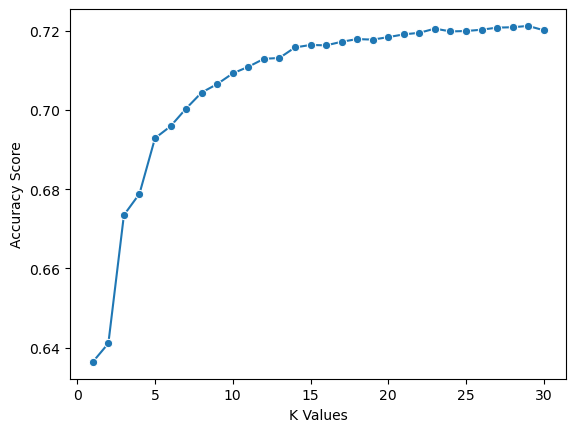

In [59]:
# Plot the values
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [60]:
# Instantiate the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=29)

In [61]:
# Train the model using the training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=29)

In [62]:
# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)

In [63]:
# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.78      0.74      8538
           1       0.75      0.66      0.70      8514

    accuracy                           0.72     17052
   macro avg       0.72      0.72      0.72     17052
weighted avg       0.72      0.72      0.72     17052



In [103]:
# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [104]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=700, random_state=78)


In [105]:
# Fit the model and use .ravel()on the "y_train" data. 
rf_model = rf_model.fit(X_train_scaled, y_train.ravel())

C:\Users\mrybi\AppData\Local\Temp\ipykernel_15556\3145931551.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  rf_model = rf_model.fit(X_train_scaled, y_train.ravel())


In [106]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [107]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [108]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,6267,2271
Actual 1,2616,5898


Accuracy Score : 0.7134060520760028
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      8538
           1       0.72      0.69      0.71      8514

    accuracy                           0.71     17052
   macro avg       0.71      0.71      0.71     17052
weighted avg       0.71      0.71      0.71     17052

